In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from skimage.morphology import medial_axis, dilation, disk
import cv2
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import sys
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
import math

In [2]:
def extract_main_skeleton_branch(skel):
    """
    Retourne uniquement la branche principale du squelette :
    celle qui part d'en haut et va le plus profond possible vers le bas.
    """
    # Coordonnées des pixels du squelette
    y, x = np.where(skel)
    points = list(zip(y, x))
    N = len(points)

    # Indexation rapide point -> index
    index = {p: i for i, p in enumerate(points)}

    # 8-voisinage
    neigh = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(1,-1),(-1,1),(1,1)]

    # Construction du graphe
    rows = []
    cols = []
    data = []

    for p in points:
        i = index[p]
        py, px = p

        for dy, dx in neigh:
            q = (py + dy, px + dx)
            if q in index:  # voisin appartenant au squelette
                j = index[q]
                rows.append(i)
                cols.append(j)
                data.append(1)  # poids = 1

    graph = csr_matrix((data, (rows, cols)), shape=(N, N))

    # Points les plus hauts (y minimal)
    top_points = np.where(y == y.min())[0]

    # Points les plus bas (y maximal)
    bottom_points = np.where(y == y.max())[0]

    # Calcul chemin le plus long entre haut et bas
    dist_matrix, predecessors = shortest_path(
        graph,
        directed=False,
        return_predecessors=True
    )

    best_path = []
    best_len = 0

    for s in top_points:
        for t in bottom_points:
            d = dist_matrix[s, t]
            if np.isfinite(d) and d > best_len:
                best_len = d
                # reconstruction du chemin
                path = []
                cur = t
                while cur != -9999:
                    path.append(points[cur])
                    cur = predecessors[s, cur]
                best_path = path[::-1]

    # Création d'un masque de squelette filtré
    main_skel = np.zeros_like(skel, dtype=bool)
    for (py, px) in best_path:
        main_skel[py, px] = True

    return main_skel

In [3]:
def trajectoire(mask,dist,plot=True):
  # Nouvelle résolution
  new_width = 150
  new_height = 150

  # Redimensionnement.
  # A remplacer par le vrai mask obtenu par le modèle.
  #mask = cv2.resize(mask, (new_width, new_height), interpolation=cv2.INTER_AREA)

  #mask = np.clip(mask, 0, 1)

  # Sélection du bleu pur (trottoir)
  mask_blue = (mask[:, :, 2] == 255) & (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0)
  print("Bleu trouvé :", mask_blue.sum())

  if plot:
    plt.imshow(mask_blue)
    plt.title("Les masque du trotoir.")
    plt.show()


  # Calcul du squelette + distances
  skel, distance = medial_axis(mask_blue, return_distance=True)

  # Masque des obstacles (noir pur)
  obstacle_mask = (mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0)

  main_skel = extract_main_skeleton_branch(skel)
  print("Pixels squelette :", skel.sum())

  dist_on_main = distance * main_skel

  # Distance uniquement sur squelette
  #dist_on_skel = distance * skel

  # --- Protection : zone dangereuse autour des obstacles ---
  rayon_secu = dist      # en pixels
  zone_dangereuse = dilation(obstacle_mask, disk(rayon_secu))

  # Collision = squelette qui touche zone interdite
  collision = main_skel & zone_dangereuse


  # ------------------------------
  #       AFFICHAGE AMÉLIORÉ
  # ------------------------------

  if plot:
    plt.figure(figsize=(12, 6))

    # --- 1. Distance au bord ---
    plt.subplot(1, 2, 1)
    im = plt.imshow(main_skel, cmap="viridis")
    plt.title("Distance au bord du trottoir")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # --- 2. Collision ---
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.imshow(collision, cmap="hot", alpha=0.7)
    plt.title(f"Zones de collision (d < {rayon_secu}px)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


  # ------------------------------
  #       MESSAGE FINAL
  # ------------------------------

  if collision.any():
      print("⚠️ Collision (ou zone trop étroite) détectée ! Décallez vous a gauche")
  else:
      print("👍 Aucun risque de collision.")

  return main_skel


In [4]:
def vecteur_directeur(main_skel):
  idx1 = np.argmax(main_skel[0])
  idx2 = np.argmax(main_skel[-1])

  point1 = np.array([idx1, 0])
  point2 = np.array([idx2, 150])

  vecteur_dir = point1 - point2

  norme = np.linalg.norm(vecteur_dir)

  # Éviter la division par zéro
  if norme == 0:
      vecteur_dir = np.array([0, 0])
  else:
      vecteur_dir = vecteur_dir / norme
  return vecteur_dir



In [5]:
# Fonction pour faire la segmentation sur une image
def predict_mask(model, processor, img):
    inputs = processor(images=img, return_tensors="pt",do_rescale=False).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    pred = logits.argmax(dim=1)[0].cpu().numpy()
    return pred

# Fonction pour décoder l'output du modèle (ID->RGB)
def decode_segmap_global(mask_tensor,dict_rgb):
    mask_array = mask_tensor
    h,w = mask_array.shape
    rgb_image = np.zeros((h,w,3),dtype=np.uint8)
    for idx, color in dict_rgb.items():
        rgb_image[mask_array==idx] = color
    return rgb_image


In [6]:
def segmentation_box(image,processor,model,vecteur_directeur):
  # Préparer l'image et prédire
  inputs = processor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  # Post-traitement pour récupérer les boîtes

  H, W = image.shape[:2]         # récupérer hauteur et largeur
  target_sizes = torch.tensor([[W, H]])
  results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

  # Coordonnées du point central (correct x/y)
  x_0 = W // 2
  y_0 = H

  fig, ax = plt.subplots(1, 1, figsize=(12, 8))
  ax.imshow(image)

  Phrases = []
  a,b = vecteur_directeur

  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      x, y, x2, y2 = [float(i) for i in box.tolist()]

      # Centre de la box
      cx = (x + x2) / 2
      cy = (y + y2) / 2
      ax.plot(cx, cy, 'bo')  # point bleu au centre

      # Ligne (segment) du centre vers le coin supérieur gauche du bounding box
      line = FancyArrowPatch((x_0, y_0), (cx, cy),
                            color='blue',
                            arrowstyle='-')
      ax.add_patch(line)

      vx = cx - x_0
      vy = cy - y_0

      norme = math.sqrt(vx**2 + vy**2)

      vx_norm = vx / norme
      vy_norm = vy / norme

      produit_scalaire = vx_norm*a+vy_norm*b

      if produit_scalaire > 0:
          devant_derriere = "devant"
      else:
          devant_derriere = "derrière"

      # Produit vectoriel 2D → gauche ou droite
      det = a*vy_norm - b*vx_norm
      if det > 0:
          gauche_droite = "à gauche"
      elif det < 0:
          gauche_droite = "à droite"
      else:
          gauche_droite = "aligné"

      Phrases.append(f"Le {model.config.id2label[label.item()]} se trouve à {( x, y, x2, y2)} {devant_derriere} à {gauche_droite}")

      # Rectangle du bounding box
      rect = patches.Rectangle((x, y), x2 - x, y2 - y,
                              linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

      # Texte de label + score
      ax.text(x, y,
              f'{model.config.id2label[label.item()]}: {score.item():.2f}',
              color='white', fontsize=12,
              bbox=dict(facecolor='red', alpha=0.5))
  plt.show()

  for phrase in Phrases:
    print(phrase)

In [7]:
import cv2
import numpy as np

def improve_mask_advanced(mask, upscale_factor=2, kernel_size=5):
    """
    Amélioration avancée d'un masque RGB/RGBA :
    1. Upscaling pour lisser
    2. Remplissage des trous avec couleur environnante
    3. Closing pour consolider les zones
    """

    # 1) Convertir en uint8 si nécessaire
    if mask.dtype != np.uint8:
        mask = np.clip(mask, 0, 255).astype(np.uint8)

    # 2) Gérer le nombre de canaux
    if mask.ndim == 2:  # grayscale -> RGB
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    elif mask.shape[2] == 4:  # RGBA -> RGB
        mask = mask[:, :, :3]
    elif mask.shape[2] == 1:  # 1 canal -> RGB
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # --- 3) Upscaling ---
    new_h = mask.shape[0] * upscale_factor
    new_w = mask.shape[1] * upscale_factor
    mask_up = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # --- 4) Détecter trous à remplir ---
    mask_gray = cv2.cvtColor(mask_up, cv2.COLOR_RGB2GRAY)
    holes = np.uint8(mask_gray == 0) * 255

    # --- 5) Inpainting ---
    mask_filled = cv2.inpaint(mask_up, holes, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # --- 6) Morphologie (closing) ---
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_final = cv2.morphologyEx(mask_filled, cv2.MORPH_CLOSE, kernel)

    return mask_final


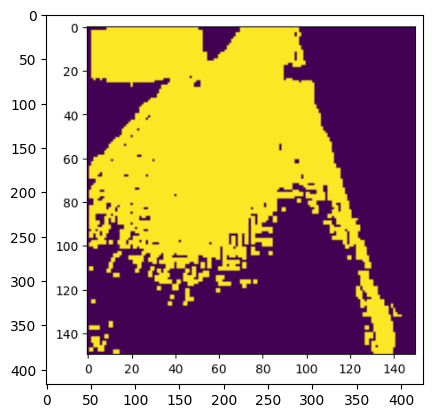

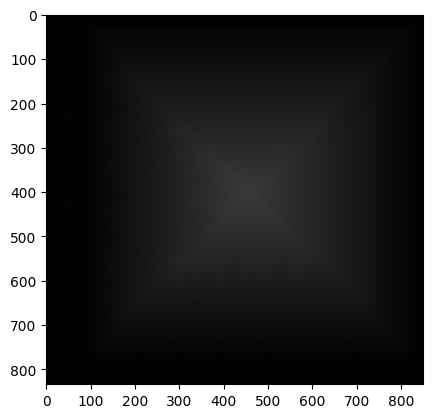

In [ ]:
path_mask = "/content/mask_pred.png"

mask = plt.imread(path_mask)

plt.imshow(mask)
plt.show()
mask_improve = improve_mask_advanced(mask)

plt.imshow(mask_improve)

In [ ]:
def full_pipeline(image):
  # On calcule le masque.
  pred_finetuned = predict_mask(model_finetuned, processor, image)
  # Ici on peut effectuer un traitement pour améliorer le masque.

  # On transforme le masque en RGB.
  pred_finetuned_rgb = decode_segmap_global(pred_finetuned,dict_korean_color)


  #### Test entre le masque réel et le maque calculé.
  main_skel = trajectoire(pred_finetuned_rgb,5,plot=False)
  #trajectoire(mask,5,plot=True)

  vecteur_dir = vecteur_directeur(main_skel)
  segmentation_box(image,processor_box,model_box,vecteur_dir)



In [ ]:
import cv2

# Assure-toi que tes fonctions et modèles sont déjà importés :
# from ton_module import full_pipeline

def capture_and_run_pipeline():
    # Ouvre la webcam (0 = webcam par défaut)
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Erreur : impossible d'accéder à la webcam")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Erreur lors de la capture de l'image")
            break

        # On peut redimensionner si nécessaire
        # frame = cv2.resize(frame, (512, 512))

        # Exécute ton pipeline sur l'image capturée
        full_pipeline(frame)

        # Affiche la webcam en direct (optionnel)
        cv2.imshow("Webcam", frame)

        # Quitte avec la touche 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# Lance la fonction
capture_and_run_pipeline()


Erreur : impossible d'accéder à la webcam


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#dictionnaire des classes
dict_korean_color = {0: (255, 128, 255), 1: (0, 0, 255), 2: (230, 170, 255), 3: (0, 0, 0), 4: (255, 155, 155), 5: (255, 255, 0), 6: (0, 255, 0)}

######################################################## - Chargment des modèles - ########################################################
# Charger le modèle de segmentation bonding box
processor_box = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model_box = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

#lien vers le dossier qui contient le modèle pré-entrainé
dossier_modele_fine_tune = "/content/Untitled Folder"

#définition du processor qui traite les images avant de les envoyer au modèle
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")

#import du modèle pré entrainé
model_finetuned = SegformerForSemanticSegmentation.from_pretrained(dossier_modele_fine_tune).to(device)
model_finetuned.eval()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

Bleu trouvé : 4813


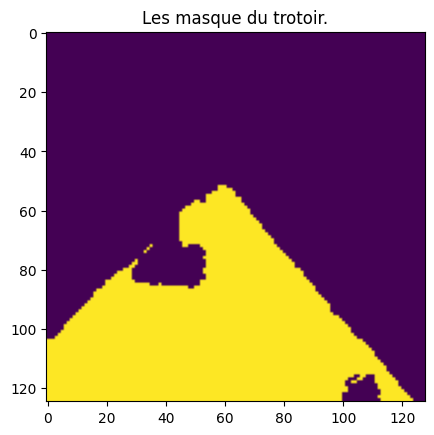

Pixels squelette : 362


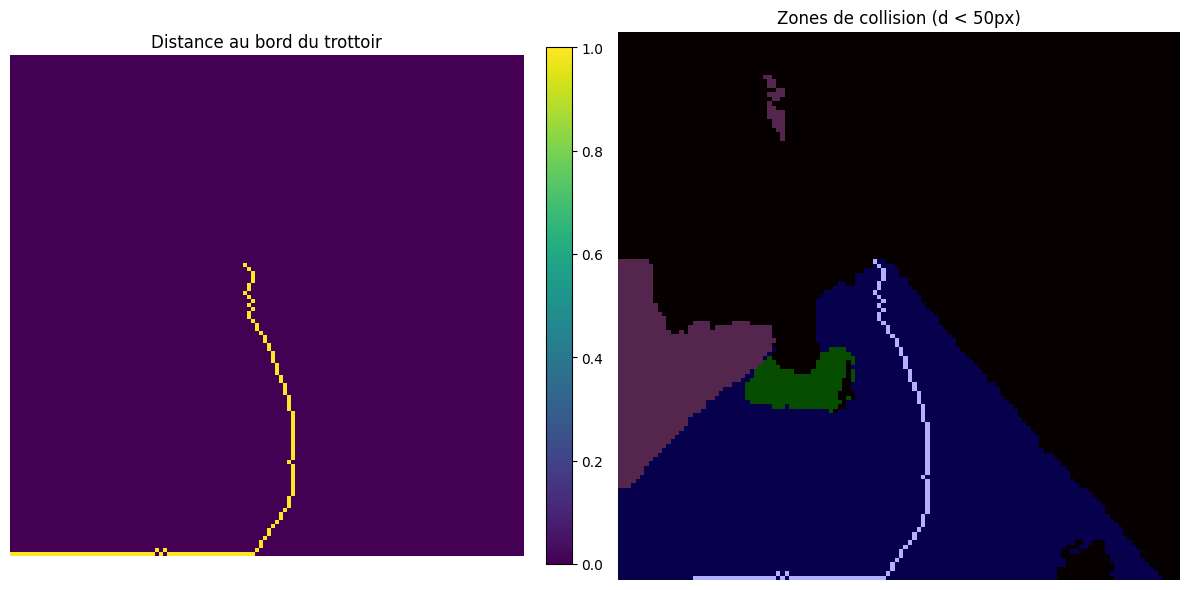

⚠️ Collision (ou zone trop étroite) détectée ! Décallez vous a gauche
[-0.38198898 -0.92416688]


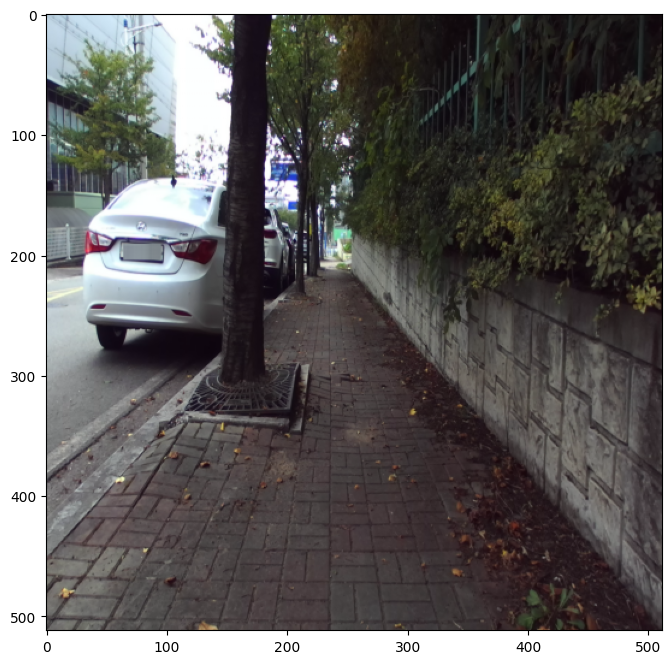

In [ ]:
######################################################## - Chargment des modèles - ########################################################

######################################################## - On importe des images et des masques - ########################################################

path_image = "/content/ZED3_KSC_091079_L_P027891.png"

######################################################## - On importe des images et des masques - ########################################################


######################################################## - On lit les images et les masques - ########################################################
image = plt.imread(path_image)
image = image[:, :, :3]

image_res = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
image_res = np.clip(image_res, 0.0, 1.0)



######################################################## - On lit les images et les masques - ########################################################

# On calcule le masque.
pred_finetuned = predict_mask(model_finetuned, processor, image_res)

# On transforme le masque en RGB.
pred_finetuned_rgb = decode_segmap_global(pred_finetuned,dict_korean_color)
pred_finetuned_rgb = pred_finetuned_rgb[:-3]
#### Test entre le masque réel et le maque calculé.
main_skel = trajectoire(pred_finetuned_rgb,50,plot=True)
main_skel = main_skel[:-3]
vecteur_dir = vecteur_directeur(main_skel)
print(vecteur_dir)
segmentation_box(image_res,processor_box,model_box,vecteur_dir)
